In [ ]:
import pandas as pd
import numpy as np
from numpy import array
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error


# Train and Validate model

In [41]:
# Import dataset: we use Apple stock price from 2011 to 2017 as our dataset
df=pd.read_csv('apple_stock+sentiment.csv')
df

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
0,0,2011-01-03,11.630000,11.795000,11.601429,11.770357,9.964778,445138400,0.130337
1,1,2011-01-04,11.872857,11.875000,11.719643,11.831786,10.016786,309080800,0.129600
2,2,2011-01-05,11.769643,11.940714,11.767857,11.928571,10.098720,255519600,-0.006950
3,3,2011-01-06,11.954286,11.973214,11.889286,11.918929,10.090557,300428800,0.037282
4,4,2011-01-07,11.928214,12.012500,11.853571,12.004286,10.162822,311931200,0.109635
...,...,...,...,...,...,...,...,...,...
1756,1756,2017-12-22,43.669998,43.855000,43.625000,43.752499,41.320251,65397600,0.024353
1757,1757,2017-12-26,42.700001,42.867500,42.419998,42.642502,40.271976,132742000,0.731350
1758,1758,2017-12-27,42.525002,42.695000,42.427502,42.650002,40.279045,85992800,-0.116108
1759,1759,2017-12-28,42.750000,42.962502,42.619999,42.770000,40.392372,65920800,0.289678


In [42]:
# Use Adj Close value as our input
df = df[['Adj Close', 'sentiment_score']]
df.head()

,Adj Close,sentiment_score
0,9.964778,0.130337
1,10.016786,0.129600
2,10.098720,-0.006950
3,10.090557,0.037282
4,10.162822,0.109635


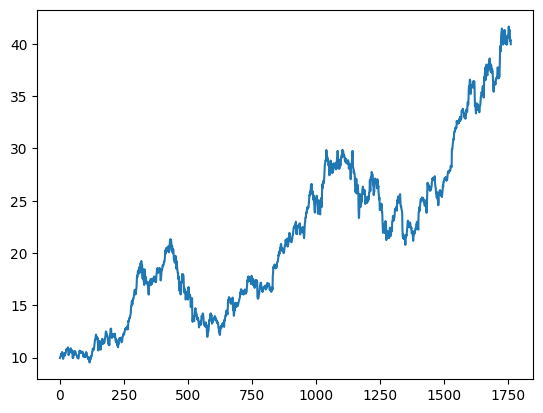

In [ ]:
plt.plot(df);
plt.show()

In [43]:
# Normalize the data using Min-Max scaling, ensuring that the values are scaled to fall within the range of 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
df[["Adj Close"]] = scaler.fit_transform(df[["Adj Close"]])
df.head()

<ipython-input-43-a670b2544c0c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[["Adj Close"]] = scaler.fit_transform(df[["Adj Close"]])


,Adj Close,sentiment_score
0,0.013414,0.130337
1,0.015034,0.129600
2,0.017585,-0.006950
3,0.017330,0.037282
4,0.019580,0.109635


In [44]:
df = df.to_numpy()
df

array([[ 0.01341442,  0.1303375 ],
       [ 0.01503364,  0.1296    ],
       [ 0.01758457, -0.00695   ],
       ...,
       [ 0.95721844, -0.11610833],
       [ 0.96074677,  0.28967778],
       [ 0.94714797,  0.39852857]])

In [46]:
# splitting dataset into train and test split
training_size = int(len(df)*0.65)
test_size = len(df)-training_size
train_data,test_data = df[0:training_size,:],df[training_size:len(df),:1]
print("Training size:", training_size)
print("Testing size:", test_size)

Training size: 1144
Testing size: 617


In [47]:
train_data

array([[ 0.01341442,  0.1303375 ],
       [ 0.01503364,  0.1296    ],
       [ 0.01758457, -0.00695   ],
       ...,
       [ 0.61246759,  0.14782353],
       [ 0.62965468, -0.008296  ],
       [ 0.62039462,  0.04108696]])

In [48]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [53]:
# In our case, we use the previous 100 days' value as the features for each data point
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [30]:
# Reshape the arrays X_train and X_test to have an additional dimension to working with RNNs where the input data needs to have a specific shape
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [49]:
# Create a Long Short-Term Memory (LSTM) neural network model using Keras with a sequential architecture.
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 50)           10600     
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 51051 (199.42 KB)
Trainable params: 51051 (199.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train our model
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=0)

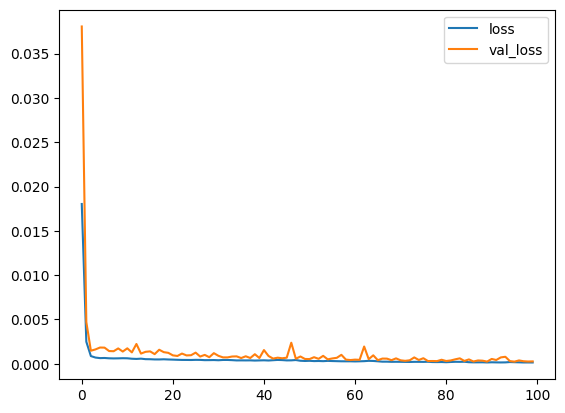

In [ ]:
# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [ ]:
# Make prediction with our model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

17/17 [==============================] - 1s 42ms/step


In [ ]:
# Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# Calculate RMSE performance metrics
print("Trainning set error:",math.sqrt(mean_squared_error(y_train,train_predict)))
print("Testing set error:",math.sqrt(mean_squared_error(y_test,test_predict)))

Trainning set error: 21.448543515069932
Testing set error: 32.23579234993904


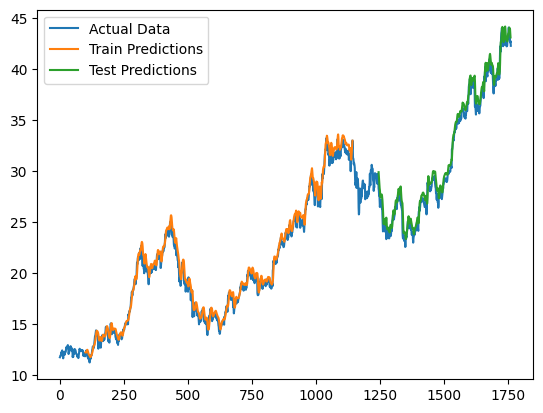

In [ ]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df), label='Actual Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.legend()
plt.show()

# Testing on second dataset

46/46 [==============================] - 5s 103ms/step
RMSE: 129.9672169096033


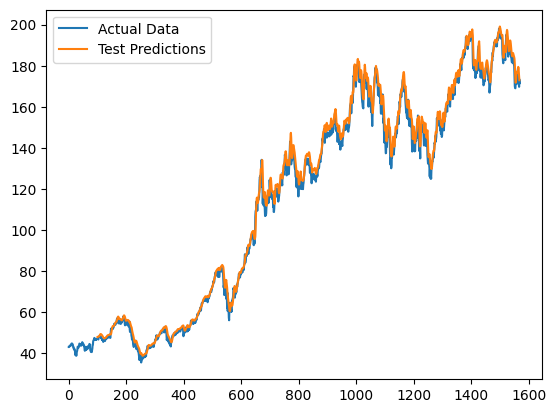

In [ ]:
# Testing on second data: Apple stock price from 2018 to 2024 to test
df1=pd.read_csv('AAPL18_24.csv')

# Use Close value as our input
df1=df1.reset_index()['Adj Close']

# Normalize the dataset
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

# Convert an array of values into a dataset matrix
X_test1 , y_test1 = create_dataset(df1, time_step)

# Reshape the arrays to have an additional dimension
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1] , 1)

# Make prediction with model
test_predict1 = model.predict(X_test1)

# Transformback to original form
test_predict1 = scaler.inverse_transform(test_predict1)

# Calculate RMSE performance metrics
print("RMSE:",math.sqrt(mean_squared_error(y_test1,test_predict1)))

# Plot the prediction with actual value
testPredictPlot1 = np.empty_like(df1)
testPredictPlot1[:, :] = np.nan
testPredictPlot1[look_back:len(test_predict1)+look_back, :] = test_predict1
plt.plot(scaler.inverse_transform(df1), label='Actual Data')
plt.plot(testPredictPlot1, label='Test Predictions')
plt.legend()
plt.show()

# Test on third dataset

37/37 [==============================] - 3s 68ms/step
RMSE: 286.9782870059125


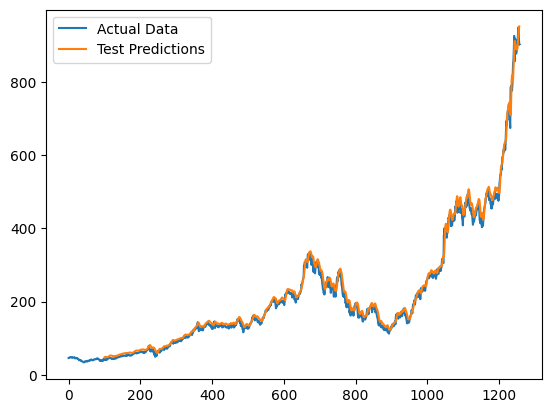

In [ ]:
# Testing on second data: Nvida stock price from 2019 to 2024 to test
df3=pd.read_csv('NVDA.csv')
df3=df3.reset_index()['Adj Close'];
df3 = scaler.fit_transform(np.array(df3).reshape(-1,1));
X_test3, y_test3 = create_dataset(df3, time_step)
X_test3 = X_test3.reshape(X_test3.shape[0],X_test3.shape[1] , 1)
test_predict_3 = model.predict(X_test3)
test_predict_3 = scaler.inverse_transform(test_predict_3)
print("RMSE:",math.sqrt(mean_squared_error(y_test3,test_predict_3)))

testPredictPlot3 = np.empty_like(df3)
testPredictPlot3[:, :] = np.nan
testPredictPlot3[look_back:len(test_predict_3)+look_back, :] = test_predict_3
plt.plot(scaler.inverse_transform(df3), label='Actual Data')
plt.plot(testPredictPlot3, label='Test Predictions')
plt.legend()
plt.show()

# Test on Forth dataset

36/36 [==============================] - 2s 43ms/step
RMSE: 64.12826942294018


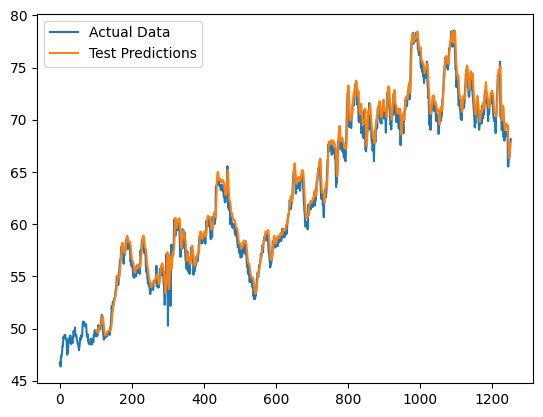

In [ ]:
# Testing on forth data: Metro Inc. stock price from 2019 to 2023 to test
df4=pd.read_csv('MRU.TO.csv')
df4=df4.reset_index()['Adj Close'];
df4 = scaler.fit_transform(np.array(df4).reshape(-1,1));
X_test4, y_test4 = create_dataset(df4, time_step)
X_test4 = X_test4.reshape(X_test4.shape[0],X_test4.shape[1] , 1)
test_predict_4 = model.predict(X_test4)
test_predict_4 = scaler.inverse_transform(test_predict_4)
print("RMSE:",math.sqrt(mean_squared_error(y_test4,test_predict_4)))

testPredictPlot4 = np.empty_like(df4)
testPredictPlot4[:, :] = np.nan
testPredictPlot4[look_back:len(test_predict_4)+look_back, :] = test_predict_4
plt.plot(scaler.inverse_transform(df4), label='Actual Data')
plt.plot(testPredictPlot4, label='Test Predictions')
plt.legend()
plt.show()

# Test on fifth dataset

37/37 [==============================] - 2s 43ms/step
RMSE: 0.812848153264356


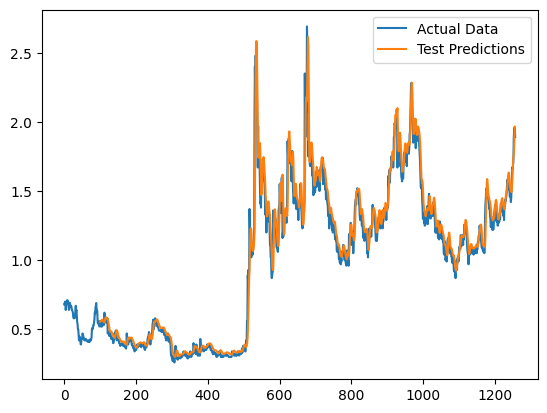

In [ ]:
# Testing on forth data: Globalstar, Inc. stock price from 2019 to 2023 to test
df5=pd.read_csv('GSAT.csv')
df5=df5.reset_index()['Adj Close'];
df5 = scaler.fit_transform(np.array(df5).reshape(-1,1));
X_test5, y_test5 = create_dataset(df5, time_step)
X_test5 = X_test5.reshape(X_test5.shape[0],X_test5.shape[1] , 1)
test_predict_5 = model.predict(X_test5)
test_predict_5 = scaler.inverse_transform(test_predict_5)
print("RMSE:",math.sqrt(mean_squared_error(y_test5,test_predict_5)))

testPredictPlot5 = np.empty_like(df5)
testPredictPlot5[:, :] = np.nan
testPredictPlot5[look_back:len(test_predict_5)+look_back, :] = test_predict_5
plt.plot(scaler.inverse_transform(df5), label='Actual Data')
plt.plot(testPredictPlot5, label='Test Predictions')
plt.legend()
plt.show()

# Demonstrate prediction for next 30 days

In [ ]:
# demonstrate prediction for next 30 days for Apple stock price
x_input = df1[1470:].reshape(1,-1) #len(test_data)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
lst_output = []
n_steps = 100
i = 0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

print(lst_output)

[0.85408694]
101
[[0.8540869355201721], [0.8640888333320618], [0.8760500550270081], [0.8883211016654968], [0.9000324010848999], [0.9107791185379028], [0.9203958511352539], [0.9288594126701355], [0.9362464547157288], [0.942703127861023], [0.9484144449234009], [0.9535765051841736], [0.9583716988563538], [0.9629527926445007], [0.9674338102340698], [0.9718865752220154], [0.9763457775115967], [0.9808125495910645], [0.9852654933929443], [0.9896689057350159], [0.9939807057380676], [0.998160183429718], [1.0021721124649048], [1.0059908628463745], [1.0096006393432617], [1.0129963159561157], [1.0161819458007812], [1.0191676616668701], [1.0219695568084717], [1.0246057510375977]]


In [ ]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

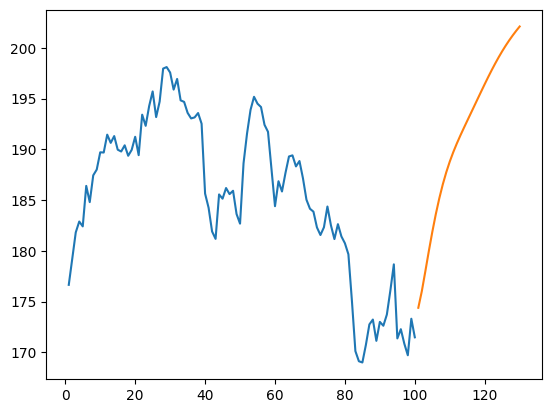

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1470:])) #len(df1)
plt.plot(day_pred,scaler.inverse_transform(lst_output))

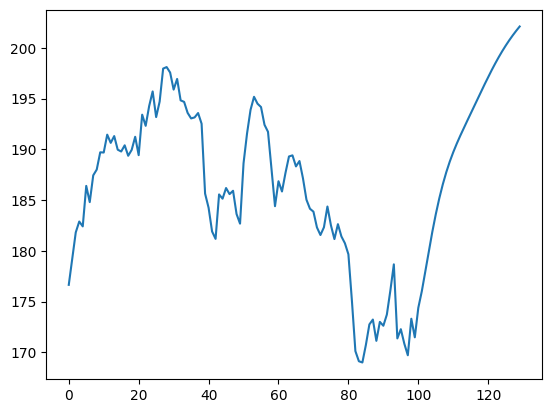

In [ ]:
df2 = df1.tolist()
df2.extend(lst_output)
df2 = scaler.inverse_transform(df2).tolist()
plt.plot(df2[1470:])

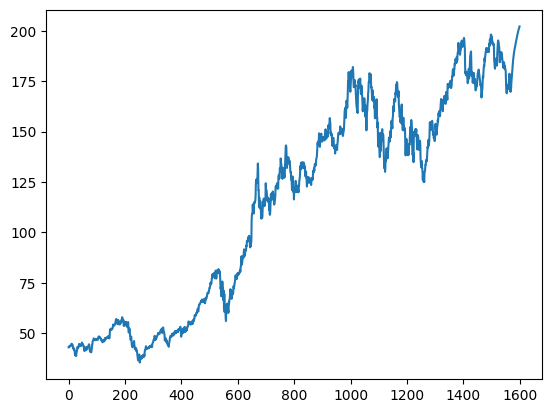

In [ ]:
plt.plot(df2)